In [6]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2

In [9]:
from mushroom.mushroom_v2 import Mushroom
import mushroom.utils as utils

In [10]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [11]:
visium_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'encoder_dim': 256,
        'kl_scaler': .001,
        'recon_scaler': 1.,
        'neigh_scaler': .1,
        'codebook_size': 100,
        'decoder_dims': (256, 1000, 5000,)
    },
    'learner_kwargs': {
        'scale': .1,
        'contrast_pct': None,
#         'pct_expression': .02,
        'batch_size': 64,
        'num_workers': 1,
        'device': 'cpu',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [12]:
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'

case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/testing/mushroom/{case}_vae_vq_visium/outputs')

config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [13]:
visium_config['sections'] = config
visium_config['train_kwargs']['save_dir'] = chkpt_dir
visium_config['chkpt_filepath'] = os.path.join(chkpt_dir, 'final.pt')

In [21]:
mushroom = Mushroom.from_config(visium_config)

INFO:root:using device: cpu
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11622 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer


In [22]:
mushroom.true_imgs.shape

torch.Size([2, 11622, 60, 60])

In [23]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

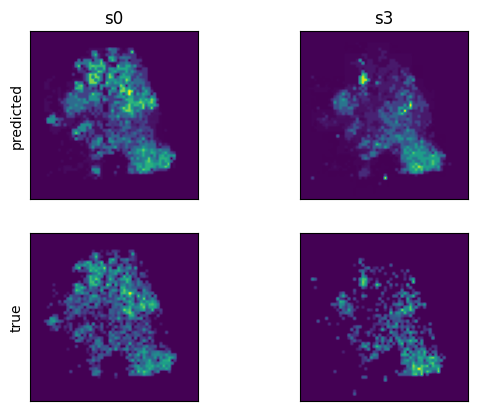

In [24]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

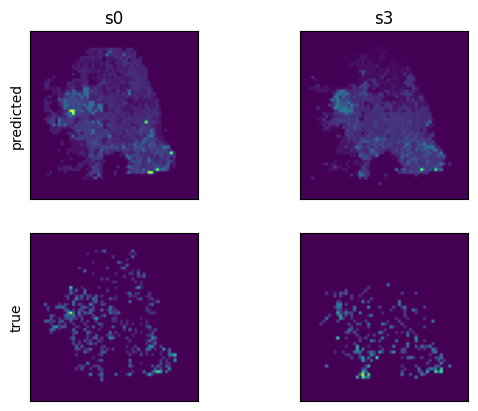

In [25]:
mushroom.display_predicted_pixels(channel='IL7R')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

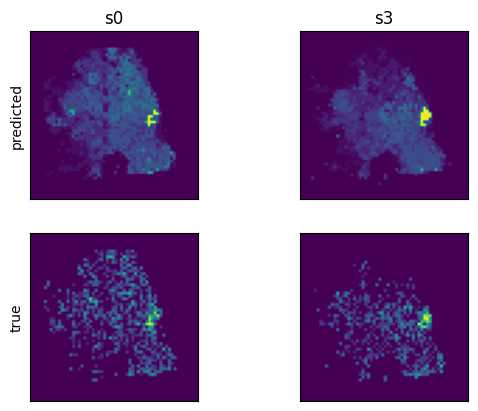

In [26]:
mushroom.display_predicted_pixels(channel='CD68')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

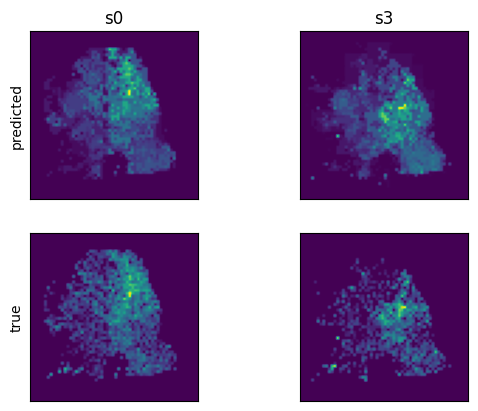

In [27]:
mushroom.display_predicted_pixels(channel='ACTA2')

In [28]:
mushroom.recon_cluster_ids.shape

torch.Size([2, 60, 60])

In [29]:
# cluster_ids = mushroom.recon_cluster_probs.argmax(dim=1).cpu().detach().numpy()
cluster_ids = mushroom.recon_cluster_ids.cpu().detach().numpy().astype(int)

In [30]:
mushroom.recon_embs.shape

torch.Size([2, 256, 60, 60])

In [31]:
cluster_ids.shape

(2, 60, 60)

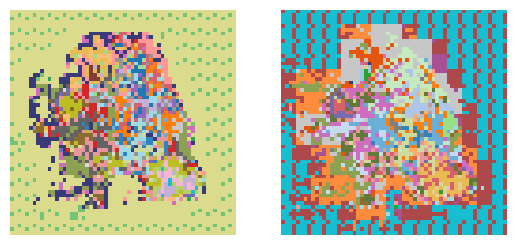

In [32]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

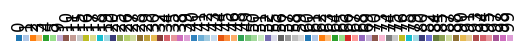

In [33]:
labels = np.unique(cluster_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l), rotation=90)
    

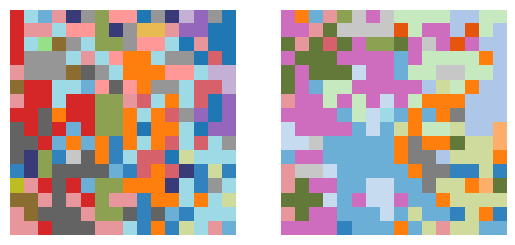

In [34]:
from mushroom.visualization.utils import display_labeled_as_rgb
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(cluster_ids))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x[20:36, 20:36], cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [226]:
mushroom.cluster_sections(margin=.1, num_clusters=20)

INFO:root:no background channel detected, defaulting to mean of all channels


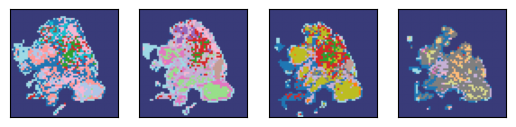

In [227]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)


In [228]:
mushroom.recon_embs.shape

torch.Size([4, 256, 60, 60])

In [229]:
mushroom.learner.sae.vq.codebook.shape

torch.Size([100, 256])

In [230]:
dists = torch.cdist(
    rearrange(mushroom.recon_embs, 'n c h w -> n h w c'),
    mushroom.learner.sae.vq.codebook
)
dists.shape

torch.Size([4, 60, 60, 100])

In [36]:
import torch.nn.functional as F

In [37]:
x = rearrange(mushroom.recon_embs, 'n c h w -> n h w c')
codebook = mushroom.learner.sae.vq.codebook
dists = torch.zeros(x.shape[0], x.shape[1], x.shape[2], codebook.shape[0])
for n in range(x.shape[0]):
    for h in range(x.shape[1]):
        for w in range(x.shape[2]):
            for c in range(codebook.shape[0]):
                dists[n, h, w, c] = F.cosine_similarity(x[n, h, w], codebook[c], dim=0)
dists.shape

torch.Size([2, 60, 60, 100])

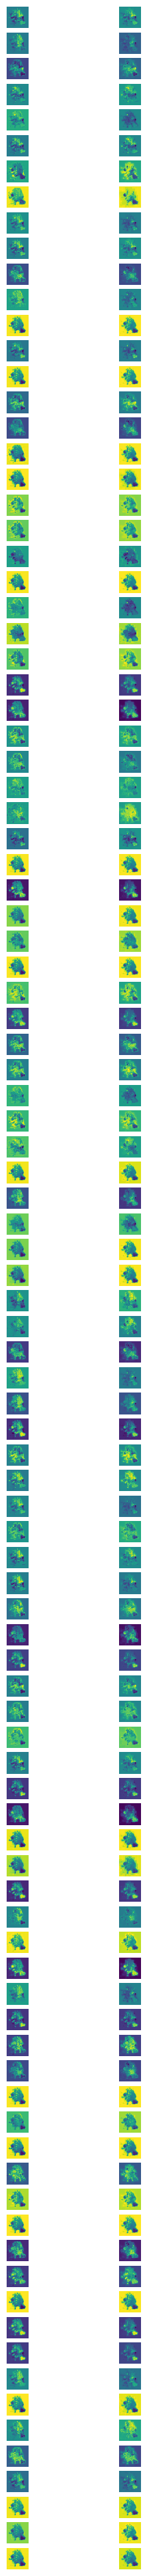

In [38]:
fig, axs = plt.subplots(nrows=dists.shape[-1], ncols=dists.shape[0], figsize=(4, 50))
for c in range(dists.shape[0]):
    for r in range(dists.shape[-1]):
        ax = axs[r, c]
        ax.imshow(dists[c, ..., r])
        ax.axis('off')
        ax.set_ylabel(r, rotation=90)

In [39]:
# fig, axs = plt.subplots(nrows=dists.shape[-1], ncols=dists.shape[0], figsize=(3, 25))
# for c in range(dists.shape[0]):
#     for r in range(dists.shape[-1]):
#         ax = axs[r, c]
#         ax.imshow(dists[c, ..., r])
#         ax.axis('off')

In [40]:
mushroom.recon_imgs.shape

torch.Size([2, 11622, 60, 60])

In [42]:
from scipy.stats import spearmanr, pearsonr

In [43]:
import torchvision.transforms.functional as TF

distances = rearrange(dists, 'n h w c -> n c h w')

patch_size = 32
exp = TF.resize(
    mushroom.true_imgs,
    (distances.shape[-2], distances.shape[-1]),
    antialias=False,
).numpy()
exp.shape

(2, 11622, 60, 60)

In [61]:
data = []

for i, channel in enumerate(mushroom.learner.channels):
    y = exp[:, i].flatten()
    row = []
    for j in range(distances.shape[1]):
        x = distances[:, j].flatten()
        corr, pval = spearmanr(x, y)
        row.append(corr)
    data.append(row)

df = pd.DataFrame(data=data, index=mushroom.learner.channels, columns=list(range(distances.shape[1])))
df = df.transpose()
df


,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,-0.018770,0.056940,-0.009478,0.085136,-0.100311,0.188208,0.105271,0.026848,0.098203,0.106590,...,0.046616,0.039656,0.082259,0.082830,0.089567,0.167471,0.040648,0.145583,0.123897,0.057112
1,0.177503,0.233015,0.306271,0.107795,0.064963,-0.105111,0.245103,0.255543,0.228723,0.149488,...,0.147469,0.153247,0.273515,0.281970,0.186595,0.212807,0.058814,0.227472,0.183044,0.066009
2,0.122493,0.411987,0.393286,0.277220,-0.005611,-0.071936,0.365747,0.358163,0.398518,0.408320,...,0.266268,0.257868,0.395229,0.438366,0.379201,0.392020,0.157656,0.391734,0.363219,0.111056
3,0.088002,0.130404,0.080109,0.082315,-0.165083,-0.004063,0.130420,0.119195,0.136058,0.096820,...,0.121013,0.093479,0.101406,0.132419,0.140895,0.191833,-0.101563,0.104703,0.113677,-0.030750
4,0.014603,-0.101773,-0.109383,-0.043824,-0.071565,-0.011824,-0.102805,-0.031062,-0.038488,-0.112052,...,-0.039145,-0.017237,-0.060004,0.009280,0.036611,-0.115072,-0.103769,-0.054594,0.012424,-0.047623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.002645,0.049666,-0.029179,0.030874,-0.129995,0.129501,0.052563,0.037124,0.094227,0.041303,...,0.001004,0.018144,0.074582,0.115021,0.107700,0.126799,-0.008120,0.136031,0.156332,-0.000100
96,0.094687,0.353970,0.280973,0.315390,-0.080653,0.015678,0.333516,0.303412,0.376709,0.432307,...,0.278538,0.248210,0.329669,0.389257,0.393494,0.403049,0.127149,0.349630,0.349532,0.107033
97,0.007732,0.207046,0.128726,0.195594,-0.134683,-0.032204,0.145753,0.167674,0.229718,0.271861,...,0.154210,0.139420,0.158421,0.244037,0.263206,0.229660,0.031717,0.157238,0.224784,-0.002194
98,0.107234,0.220050,0.281027,0.126531,0.094400,-0.144834,0.167894,0.194976,0.297457,0.188128,...,0.164804,0.153354,0.240916,0.239753,0.224910,0.198324,0.064081,0.162042,0.254822,0.046041


In [71]:
df.sort_values('CD31', ascending=False)

,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
15,0.221804,0.480762,0.429821,0.362211,-0.091665,-0.026754,0.474014,0.439364,0.500033,0.481665,...,0.373754,0.324859,0.469831,0.518472,0.480076,0.547212,0.098081,0.474851,0.441578,0.128684
87,0.237836,0.475251,0.405551,0.336316,-0.121321,0.005536,0.457322,0.434219,0.559000,0.449730,...,0.365530,0.327434,0.486951,0.534826,0.523194,0.582254,0.063848,0.501043,0.523441,0.112357
89,0.227768,0.427709,0.353750,0.370449,-0.088273,0.085934,0.474729,0.389438,0.508135,0.464585,...,0.394910,0.316443,0.418608,0.428998,0.419798,0.606338,0.105756,0.414713,0.418587,0.170229
63,0.202063,0.412834,0.417966,0.336806,0.011386,-0.071475,0.430054,0.405331,0.443651,0.427653,...,0.365043,0.291697,0.387064,0.423650,0.354634,0.495363,0.134479,0.329004,0.340273,0.155497
2,0.122493,0.411987,0.393286,0.277220,-0.005611,-0.071936,0.365747,0.358163,0.398518,0.408320,...,0.266268,0.257868,0.395229,0.438366,0.379201,0.392020,0.157656,0.391734,0.363219,0.111056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60,-0.194838,-0.286338,-0.289580,-0.230008,0.039063,0.059404,-0.285626,-0.324349,-0.349023,-0.276193,...,-0.257379,-0.263718,-0.334141,-0.402032,-0.409954,-0.296542,-0.051247,-0.302097,-0.321248,-0.097289
30,-0.197581,-0.375931,-0.288183,-0.270434,0.145038,-0.044255,-0.399304,-0.318802,-0.546352,-0.377834,...,-0.315074,-0.273502,-0.390089,-0.419369,-0.448015,-0.589841,-0.006124,-0.404549,-0.492353,-0.086515
9,-0.165952,-0.392166,-0.291410,-0.244724,0.212808,0.081043,-0.319166,-0.330426,-0.535025,-0.368856,...,-0.285153,-0.270272,-0.386697,-0.478114,-0.546668,-0.495677,0.079351,-0.422520,-0.550393,0.005450
74,-0.194246,-0.423008,-0.314810,-0.273983,0.211694,0.012904,-0.389463,-0.352211,-0.615612,-0.410867,...,-0.326463,-0.298450,-0.433695,-0.494589,-0.574356,-0.610529,0.058382,-0.472649,-0.605377,-0.033432


In [ ]:
df.sort_values('CD31', ascending=False)

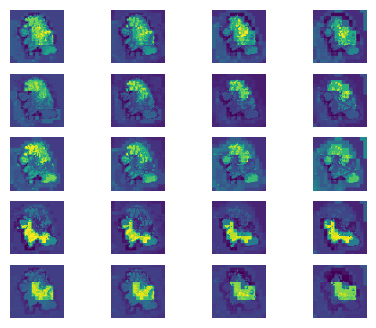

In [67]:
clusters = df.sort_values('CD31', ascending=False).index.to_list()[:5]
fig, axs = plt.subplots(nrows=len(clusters), ncols=distances.shape[0], figsize=(5, 4))
for i, cluster in enumerate(clusters):
    for j in range(distances.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(distances[j, cluster])
        ax.axis('off')

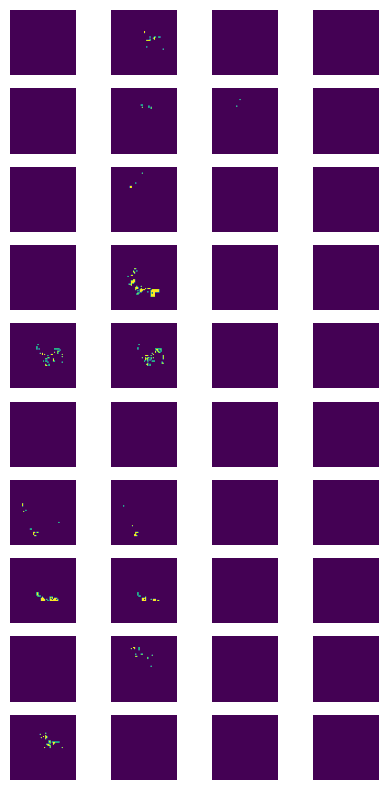

In [76]:
clusters = df.sort_values('CD31', ascending=False).index.to_list()[:10]
fig, axs = plt.subplots(nrows=len(clusters), ncols=cluster_ids.shape[0], figsize=(5, 10))
for i, cluster in enumerate(clusters):
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
#         ax.imshow(exp[j, mushroom.learner.channels.index('CD31')])
        ax.imshow(cluster_ids[j]==cluster)
        ax.axis('off')

In [77]:
distances.shape

torch.Size([4, 100, 60, 60])

In [44]:
# cluster based on cos emb

from sklearn.cluster import AgglomerativeClustering
dist = 20.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(
    rearrange(distances, 'n c h w -> (n h w) c')
)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(rearrange(cluster_ids, 'n h w -> (n h w)'), clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

13

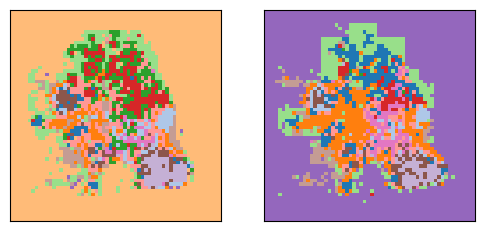

In [45]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

In [69]:
counts = Counter(cluster_ids.flatten())

In [70]:
[counts[c] for c in clusters]

[17, 9, 6, 95, 99]

In [73]:
cluster_ids.shape

(4, 60, 60)

In [52]:
F.cosine_similarity(
    torch.rand(256),
    torch.rand(20, 256)
).shape

torch.Size([20])

In [48]:
F.cosine_similarity(x[...], codebook, dim=-1)

RuntimeError: The size of tensor a (60) must match the size of tensor b (40) at non-singleton dimension 2

In [39]:
import torch.nn.functional as F

In [45]:
x[n, h, w].shape, codebook[c].shape

(torch.Size([256]), torch.Size([256]))

In [ ]:
F.cosine_similarity()

In [67]:
mushroom.learner.sae.scale_factors(torch.tensor([0, 1, 2, 3]))[:, mushroom.learner.channels.index('CD45')]

tensor([ 1.6012, -0.7417,  2.3597,  0.6643], grad_fn=<SelectBackward0>)

In [152]:
ds = mushroom.learner.inference_ds

imgs = []
for idx in range(len(ds)):
    section_idx, row_idx, col_idx = ds.idx_to_coord[idx]
    section = ds.sections[section_idx]
    img = ds.section_to_tiles[section][row_idx, col_idx]
    imgs.append(img)
imgs = torch.stack(imgs)

recon_labeled = torch.stack(
    [ds.section_from_tiles(
        imgs, i,
#         size=(mushroom.learner.train_transform.output_size[0], mushroom.learner.train_transform.output_size[1])
    ) for i in range(len(ds.sections))]
)

In [153]:
with torch.no_grad():
    h, w = mushroom.recon_embs.shape[-2], mushroom.recon_embs.shape[-1]
    _, indices, _ = mushroom.learner.sae.vq(
        rearrange(mushroom.recon_embs.to(mushroom.learner.device), 'n d h w -> n (h w) d'))
    indices = rearrange(indices, 'n (h w) -> n h w', h=h, w=w).detach().cpu().numpy()

In [154]:
indices.shape

(4, 60, 60)

In [155]:
def relabel(labels):
    new = np.zeros_like(labels, dtype=labels.dtype)
    ids = np.unique(labels)
    for i in range(len(ids)):
        new[labels==ids[i]] = i
        
    return new

cluster_ids = relabel(indices)
cluster_ids.shape

(4, 60, 60)

In [156]:
np.unique(cluster_ids)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

In [157]:
import torchvision.transforms.functional as TF
patch_size = 32
resized_cluster_ids = TF.resize(
    torch.tensor(cluster_ids),
    (recon_labeled.shape[-2], recon_labeled.shape[-1]),
    antialias=False,
    interpolation=TF.InterpolationMode.NEAREST
).numpy()
resized_cluster_ids.shape

(4, 1920, 1920)

In [158]:
exp = []
ids = np.unique(cluster_ids)
for i in ids:
#     mask = cluster_ids == int(i)
    mask = resized_cluster_ids == int(i)
#     x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    x = rearrange(mushroom.true_imgs, 'n d h w -> d n h w')
    exp.append(x[:, mask].mean(-1))

    
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels, index=ids)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


,Bap1,CD31,CD45,CD68,CD8,CK14,CK19,COX6c,DAPI,ER,...,Her2,Ki67,MGP,PLAT/tPA,PR,Pan-Cytokeratin,Podoplanin,SMA,Vimentin,cKit
0,0.135653,0.060309,0.196396,0.084181,0.013518,0.598725,0.195443,0.215644,0.444009,0.125297,...,0.095422,0.034396,0.549867,0.322370,0.230392,0.335231,0.052833,0.265551,0.286387,0.300481
1,0.102662,0.173230,0.313449,0.315419,0.014049,0.274893,0.272267,0.569661,0.479456,0.263666,...,0.165185,0.061895,0.556276,0.542538,0.306345,0.359909,0.240782,0.338380,0.344366,0.243293
2,0.214952,0.086508,0.438146,0.121400,0.039791,0.314652,0.387735,0.349714,0.633796,0.299786,...,0.233972,0.081543,0.602326,0.489407,0.410037,0.528037,0.050058,0.116576,0.319623,0.362398
3,0.022327,0.032272,0.055813,0.011232,0.013195,0.341353,0.022897,0.041572,0.203219,0.020234,...,0.015059,0.007722,0.209161,0.082997,0.137239,0.045026,0.040476,0.085965,0.160596,0.086382
4,0.256484,0.110080,0.410596,0.186311,0.034289,0.079270,0.329909,0.281702,0.535213,0.108658,...,0.121026,0.072120,0.468117,0.402524,0.285144,0.390914,0.034853,0.217675,0.285680,0.142077
5,0.038013,0.337285,0.320056,0.039905,0.052600,0.031877,0.009616,0.107503,0.552326,0.149213,...,0.063098,0.008852,0.479800,0.413995,0.210459,0.028443,0.123138,0.179513,0.679011,0.028706
6,0.062572,0.164464,0.509942,0.090697,0.132576,0.128912,0.083346,0.265080,0.551418,0.270902,...,0.073928,0.034386,0.338568,0.324116,0.215226,0.105915,0.217390,0.163324,0.496575,0.048772
7,0.002854,0.005045,0.006762,0.012790,0.005507,0.017818,0.002802,0.011778,0.075780,0.002625,...,0.002390,0.001510,0.070056,0.028942,0.026011,0.004326,0.022011,0.006881,0.032040,0.024085
8,0.357306,0.083924,0.494554,0.279103,0.035373,0.468541,0.601380,0.455954,0.726510,0.435172,...,0.390400,0.082502,0.756228,0.668009,0.514317,0.757924,0.064142,0.126356,0.212150,0.549721
9,0.179852,0.127740,0.350419,0.140682,0.016917,0.665297,0.227919,0.333807,0.438176,0.237972,...,0.152382,0.065271,0.572133,0.497277,0.307379,0.330070,0.350288,0.519348,0.472404,0.241629


In [159]:
from mushroom.visualization.utils import display_labeled_as_rgb

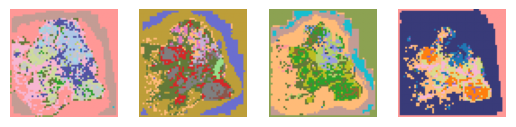

In [160]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c') + sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
fig, axs = plt.subplots(ncols=len(ds.sections))
for ax, x in zip(axs, cluster_ids):
    x = display_labeled_as_rgb(x, cmap=cmap)
    ax.imshow(x)
    ax.axis('off')

In [77]:
np.unique(cluster_ids, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 array([ 216,  331,   32,  130,  206,  593,   99,  127, 3043,  792, 2913,
         191, 1452,  125,  644,   13,   61,   48,  522,   44,  164,  177,
           7,   18,  214,   17,  123,   13, 2079,    6]))

In [78]:

from sklearn.cluster import AgglomerativeClustering
dist = 50.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

13

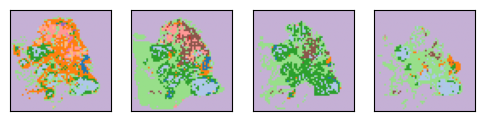

In [79]:
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

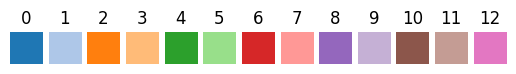

In [80]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

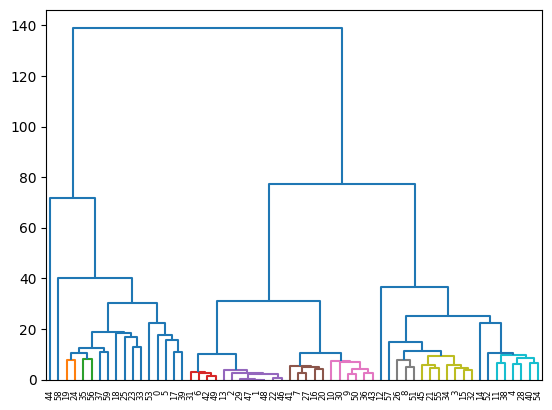

In [150]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())